# Using MCMC Samplers

This notebook demonstrates the use of the available MCMC samplers to do parameter estimation in a simple Bayesian model. We will use the same simple model defined in the previous notebook. The cell below imports some required package, and sets up the model.

In [1]:
import numpy as np
from openmcmc.model import Model
from openmcmc.distribution.location_scale import Normal


mdl = Model([Normal('y', mean='h', precision='tau'),
             Normal('h', mean='mu', precision='lambda')])

state = {}
state['y'] = np.array([150, 155, 190, 160, 173], ndmin=2)
state['h'] = np.array(200, ndmin=2)
state['tau'] = np.array(1 / 200, ndmin=2)
state['mu'] = np.array(160, ndmin=2)
state['lambda'] = np.array(1 / 100, ndmin=2)

In this example, the aim is to estimate the value of $h$, given our prior beliefs about its value, and that we have 5 observations drawn from a normal distribution with mean $h$ and standard deviation $\sqrt{200}$.

## Metropolis-Hastings sampler with random walk proposal

The simplest available type of sampler is the Metropolis-Hastings sampler with a random walk proposal. An introduction to the Metropolis-Hastings algorithm can be found on [this](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) wikipedia page. At each iteration of the algorithm, a new value of $h$ is proposed by perturbiung the current value of $h$ as follows:
$$h^* = h + \sigma\epsilon$$
The proposed value is then accepted with probability $A(h^*, h)$: in this instance
$$A(h^*, h) = \frac{f(h^*|y)}{f(h|y)}$$
which is simply the ratio of the posterior densities at the proposed and current values of $h$, owing to the symmetry of the proposal mechanism. $\sigma$ is a step-size parameter (which the user can specify as the `step` argument of the constructor), that can be tuned to achieve a desired acceptance rate.

The cell below sets up the list of samplers required to do parameter estimation in this model (in this case, just a single `RandomWalk` sampler).

In [2]:
from openmcmc.sampler.metropolis_hastings import RandomWalk

sampler= [RandomWalk('h', model=mdl, step=5.0)]

This sampler list is then passed as an input to an `MCMC` object, which controls the overall running of the MCMC chain.

In [3]:
from openmcmc.mcmc import MCMC

m = MCMC(state, sampler, model=mdl, n_burn=0, n_iter=1000)

The argument `n_burn` controls the number of burn-in iterations of the chain (these give the sampler time to converge to sampling from the target distribution). The argument `n_iter` controls the number of main iterations of the chain (run once the chain has converged to the target distribution, used for calculating parameter estimates etc.)

The MCMC algorithm is then run simply using the following command:

In [4]:
m.run_mcmc()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6678.80it/s]

h: Acceptance rate 70%


The acceptance rate for the RandomWalk sampler is printed out. An optimal Random Walk sampler has between 25-50% acceptance rate. If the step size is too small, we will get a high acceptance rate, but the chain will be slow to explore the target distribution; but if the step size is too large, the steps will traverse the distribution quicker, but stand a greater chance of getting rejected.

We can examine the results of the mcmc run by looking into the store property which has a dictionary for each estimated parameter. Only iterations post burn in will be kept so the here we have n_iter samples

In [5]:
m.store['h']

array([[200.        , 200.        , 196.12591055, 196.12591055,
        196.12591055, 196.12591055, 196.12591055, 193.15416805,
        193.15416805, 193.15416805, 193.50094715, 193.50094715,
        193.50094715, 193.50094715, 193.50094715, 193.50094715,
        193.50094715, 189.66220689, 181.90096982, 176.78061051,
        176.73400354, 171.61472827, 168.28827923, 170.1610793 ,
        170.1610793 , 170.1610793 , 168.91514529, 163.90744937,
        159.30872409, 161.22889992, 166.4618311 , 164.82014259,
        166.54627525, 170.59062474, 166.89672584, 171.37230818,
        172.56836864, 174.91502189, 169.45461566, 164.03686578,
        162.86718127, 159.35024636, 159.35024636, 159.35024636,
        159.35024636, 164.79330115, 166.21123607, 164.53818332,
        166.59387229, 165.21029973, 165.21029973, 153.75652149,
        153.70601754, 156.30120648, 154.99847213, 154.06528216,
        152.38049465, 157.21714042, 155.37844415, 155.37844415,
        166.3532031 , 162.2219225 , 162.

We can look at a trace plot of the history of the markov chain

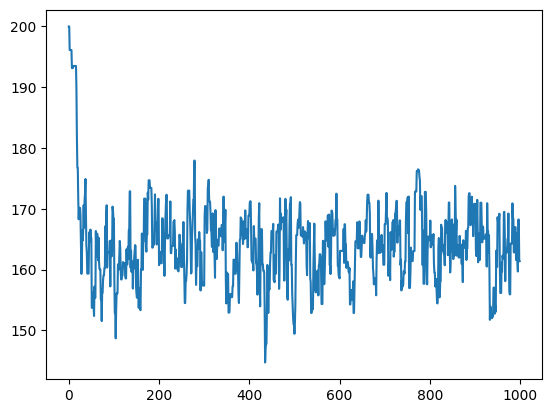

In [6]:
import matplotlib.pyplot as plt

plt.plot(m.store['h'].flatten())
plt.show()

## Conjugate sampler

When the prior distribution chosen for a parameter is conjugate to the likelihood distribution (see [here](https://en.wikipedia.org/wiki/Conjugate_prior) for more detail), this special structure can be exploited in the MCMC sampler. In this example, the posterior for $h$ will also be a Normal distribution (and in more general models, the conditional distribution given fixed values of the other parameters would still be Normal).

The `NormalNormal` sampler accommodates this situation. Exploiting this structure in the model generally gives rise to a much more efficient sampler, with no step size parameter that needs to be tuned.

A `NormalNormal` sampler for this situation can be set up and run as follows:

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7239.76it/s]


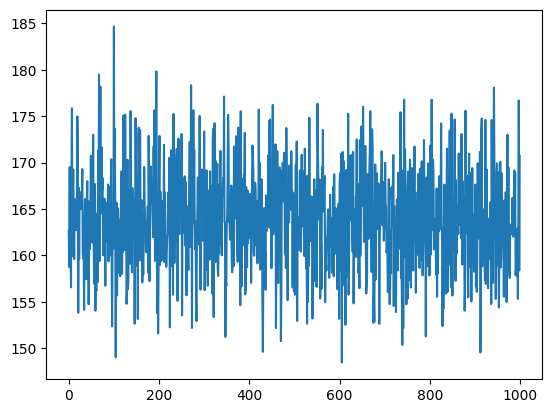

In [7]:
from openmcmc.sampler.sampler import NormalNormal

sampler= [NormalNormal('h', model=mdl)]
m = MCMC(state, sampler, model=mdl, n_burn=0, n_iter=1000)

m.run_mcmc()

plt.plot(m.store['h'].flatten())
plt.show()